In [ ]:
'''
TODO: PREPROCESSING
    - Generate masks from json files.
    - Add image_path, mask_path, json_path and background path to database.
    - Load them into list of tuples in the format of numpy array from database and shuffle.
    - Augment images and append to list.
    - Split into train and val data.
    - Train images using U-net segmentation model.
'''


In [1]:
import os
import numpy as  np
import matplotlib.pyplot as plt
import json
import config
from matplotlib.path import Path
import cv2
from dataset import *
from model import *
from dataset.augment import *


In [2]:
'''
Generate masks from json files and store in mask folder
# '''
# count = 0
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     if file.split('.')[1] == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file) 
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file.split('.')[0]+'.jpg')
#         generate_mask(jpg_file, json_file)


'\nGenerate masks from json files and store in mask folder\n# '

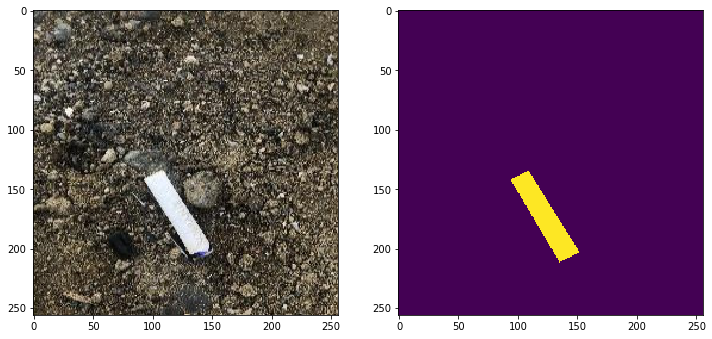

In [3]:
'''
Test with one image and mask
'''

json_files = os.listdir(config.MASK_DIRECTORY)
index = 20

mask_file = os.path.join(config.MASK_DIRECTORY, json_files[index])
jpg_file = mask_file.split('/')[-1].split('.')[0]
jpg_file = os.path.join(config.IMAGE_DIRECTORY, jpg_file+'.jpg')

img = plt.imread(jpg_file)
mask = np.load(mask_file)
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)


['IMG_6564.jpg', '00000103.jpg', 'IMG_6567.jpg', '00000550.jpg', 'IMG_6331.jpg'] ['00000609.npy', '00000587.npy', 'IMG_20200306_164230.npy', 'IMG_6396.npy', 'IMG_20200307_164356.npy']


In [4]:
'''
Add to database
'''
db = Dataset(config.DB_PATH)
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     extension = file.split('/')[-1].split('.')[-1]
#     file_name = file.split('/')[-1].split('.')[0]
#     if extension == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file)
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file_name+'.jpg')
#         mask_file = os.path.join(config.MASK_DIRECTORY, file_name+'.npy') 
#         db.add_Paths(jpg_file, mask_file, json_file, db.con)




In [5]:
'''
Load paths to list in the format of tuples
'''
util = Utils(db.load_paths(db.con, 609)) # we have 609 images in database
train_ds = util.load_images()
random.shuffle(train_ds)

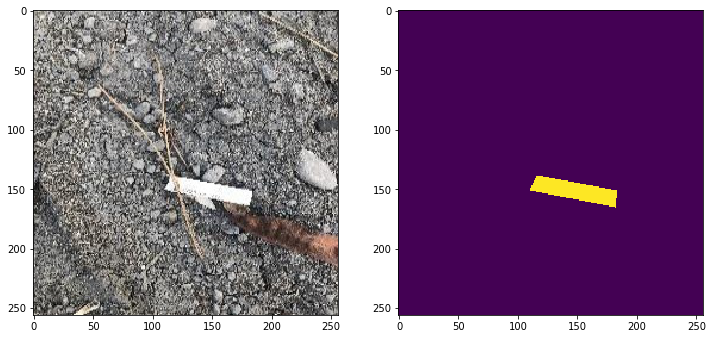

In [6]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(train_ds[0][0])
ax[1].imshow(train_ds[0][1])


In [7]:
'''fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

Augment train data
'''

def augment(tr_ds, init_step, nb_augment, augment_method):
    for count in range(nb_augment): 
        train_ds.append(augment_method(train_ds[init_step+count][0], train_ds[init_step+count][1]))    
    return train_ds

def over_bg_augment(tr_ds, init_step, nb_augment):
    bg_images = os.listdir(config.BACKGROUND_DIRECTORY)
    nb_images = len(os.listdir(config.BACKGROUND_DIRECTORY))
    
    for count in range(nb_augment):
        rnd = random.randint(0, nb_images - 1)
        bg_image = plt.imread(os.path.join(config.BACKGROUND_DIRECTORY, bg_images[rnd]))
        tr_ds.append(generate_img_over_bg(train_ds[init_step+count][0], train_ds[init_step+count][1], bg_image))
    return tr_ds

In [8]:
train_ds = augment(train_ds, 0, 200, flip_augment)
train_ds = augment(train_ds, 500, 600, rotate_augment)
train_ds = over_bg_augment(train_ds, 1100, 400)

In [9]:
len(train_ds)

809

In [10]:
def view_img_mask(img, mask):
    fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
    ax[0].imshow(img)
    ax[1].imshow(mask)

In [11]:
import os
import sys
import time
import random
import pprint
from collections import OrderedDict

import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



class CustomMetrics(Callback):
    def __init__(self, model, X_val, y_val, num_thresholds):
        super(CustomMetrics, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.num_thresholds = num_thresholds

    def on_epoch_end(self, epoch, logs={}):
        num_thresholds = self.num_thresholds
        thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]
        custom_val_metrics = list()

        y_pred = tf.reshape(self.model.predict(self.X_val), [-1])
        y_true = tf.reshape(self.y_val, [-1])

        for thresh in thresholds:
            pred_classes = tf.cast(tf.math.greater(y_pred, tf.constant([thresh])), dtype=tf.float32)
            cm = tf.math.confusion_matrix(y_true, pred_classes, num_classes=2)

            tn = cm[0][0].numpy()
            fp = cm[0][1].numpy()
            fn = cm[1][0].numpy()
            tp = cm[1][1].numpy()

            precision = tp / (tp + fp + K.epsilon())
            recall = tp / (tp + fn + K.epsilon())
            f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

            payload = \
                OrderedDict([('val_auc', logs.get('val_auc')),
                             ('val_f1', f1),
                             ('precision', precision),
                             ('recall', recall),
                             ('val_tp', tp),
                             ('val_tn', tn),
                             ('val_fp', fp),
                             ('val_fn', fn),
                             ('thresh', thresh)])

            custom_val_metrics.append(payload)
        best_val_f1 = sorted(custom_val_metrics, key=lambda x: x['val_f1'], reverse=True)[0]
        pprint.pprint(best_val_f1)

        

In [12]:

def get_model(data, name="UNET-BASE", **params):
    def _get_log_weight_dirs(name, dt):
        _dt = dt.strftime("%Y_%m_%d_T%H_%M_%S")
        relative_dt_dir = os.path.join(name, _dt)
        dt_dir = os.path.join(config.MODEL_OUT_DIR, relative_dt_dir)
        return os.path.join(dt_dir, 'logs'), os.path.join(dt_dir, 'weights')


    start_filter = params.get('START_FILTER')
    middle_filter = params.get('MIDDLE_FILTERS')
    drop_rate = params.get('DROP_RATE')
    epochs = params.get('EPOCHS')
    batch_size = params.get('BATCH_SIZE')
    num_thresholds = params.get('NUM_THRESHOLDS')

    MODEL_OUT = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out'
    assert np.mod(np.log2(start_filter), 1) == 0.0
    assert np.mod(np.log2(middle_filter), 1) == 0.0
    assert middle_filter >= start_filter

    depth = np.int(np.log2(middle_filter) - np.log2(start_filter))
    
    (tr_ds, mask_ds),(val_ds, val_mask_ds) = split_train_val(train_ds)
    
    
    X_train = tf.cast(np.array(tr_ds), tf.float32)
    y_train = tf.cast(mask_ds, tf.float32)
    X_val = tf.cast(np.array(val_ds), tf.float32)
    y_val = tf.cast(val_mask_ds, tf.float32)


    input_channels = X_train.shape[-1]
    output_channels = y_train.shape[-1]

    weight_dir = MODEL_OUT
    log_dir = MODEL_OUT
    weight_path = str(os.path.join(weight_dir, 'weight.h5'))

    inputs = Input(shape=(config.IMG_WIDTH, config.IMG_HEIGHT, 3), name="inputs")
    temp = Lambda(lambda x: x / config.IMG_MAX_VAL, name="normalize")(inputs)

    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    dconvs = list()

    i = 0
    for i in range(depth):
        dconv_1 = Conv2D(filters=start_filter * np.power(2, i), kernel_size=(3, 3), strides=1, padding='same',
                         activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                         name=f'dconv_1_level_{i}')(temp)
        dconv_2 = Conv2D(filters=start_filter * np.power(2, i), kernel_size=(3, 3), strides=1, padding='same',
                         activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                         name=f'dconv_2_level_{i}')(dconv_1)
        dconvs.append(dconv_2)
        pool = MaxPooling2D((2, 2))(dconv_2)
        drop = Dropout(drop_rate, seed=313)(pool)
        temp = drop

    convm_1 = Conv2D(filters=start_filter * np.power(2, i + 1), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_1')(temp)
    convm_2 = Conv2D(filters=start_filter * np.power(2, i + 1), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_2')(convm_1)

    temp = convm_2
    for i in range(depth - 1, -1, -1):
        deconv = Conv2DTranspose(start_filter * np.power(2, i), (4, 4), strides=(2, 2), padding="same",
                                 kernel_initializer=k_init, bias_initializer=b_init, name=f'deconv_level_{i}')(temp)
        concat = concatenate([deconv, dconvs.pop()], name=f'concat_level_{i}')
        drop = Dropout(drop_rate, seed=313)(concat)
        uconv_1 = Conv2D(start_filter * np.power(2, i), (3, 3), activation="relu", padding="same",
                         kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_1_level_{i}')(drop)
        uconv_2 = Conv2D(start_filter * np.power(2, i), (3, 3), activation="relu", padding="same",
                         kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_2_level_{i}')(uconv_1)
        temp = uconv_2

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid", kernel_initializer=k_init,
                     bias_initializer=b_init, name="outputs")(temp)

    model = Model(inputs=inputs, outputs=outputs)


    auc = AUC(num_thresholds=num_thresholds, curve='PR', name='auc')
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[auc])

    tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    model_checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
    custom_metrics = CustomMetrics(model, X_val, y_val, num_thresholds)

    history = model.fit(X_train, y_train,
                        validation_data=[X_val, y_val],
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint, reduce_lr, custom_metrics, tensorboard_callback],
                        shuffle=False,
                        verbose=1)

    model.load_weights(weight_path)


    return history, model


In [13]:
def split_train_val(data):
    '''
    Splitting the data into train and validation set for u-net segmentation model.
    Args: 
        data
    Returns:
        (tr_ds, mask_ds), (val_ds, mask_val_ds)
    '''
    def _split(data, init_step, len_new):
        x_ds, y_ds = list(), list()
        for i in range(len_new):
            x_ds.append(data[i + init_step][0])
            y_ds.append(data[i + init_step][1])
        y_ds = np.array(y_ds).reshape(len_new, config.IMG_HEIGHT, config.IMG_WIDTH, 1)

        return x_ds, y_ds
        

    data_len = len(data)
    tr_len = int(data_len * 0.75)
    val_len = data_len - tr_len

    tr_ds, mask_ds = _split(data, 0, tr_len)
    val_ds, val_mask_ds = _split(data, tr_len, val_len)
    
    return (tr_ds, mask_ds), (val_ds, val_mask_ds)




In [14]:
(tr, mask),(val, val_mask) = split_train_val(train_ds)

In [15]:
len(val_mask)

203

In [16]:

UNET_CONFIG = {
    'START_FILTER': 16,
    'MIDDLE_FILTERS': 256,
    'DROP_RATE': 0.3,
    'EPOCHS': 30,
    'BATCH_SIZE': 32,
    'NUM_THRESHOLDS': 50
}


base_model = get_model(train_ds, **UNET_CONFIG)
# dt = np.array(train_ds[0][0])

Train on 606 samples, validate on 203 samples
Epoch 1/30
 32/606 [>.............................] - ETA: 3:37WARNING:tensorflow:Can save best model only with val_loss available, skipping.


ResourceExhaustedError:  OOM when allocating tensor with shape[32,16,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/dconv_2_level_0/Conv2D (defined at /home/elmar/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  252.25MiB from model/dconv_1_level_0/Conv2D
 [Op:__inference_distributed_function_5072]

Function call stack:
distributed_function


In [ ]:

from tensorflow.keras.models import load_model
# base_model[1].save('auc_83.h5')
base_model = load_model('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/auc_83.h5')

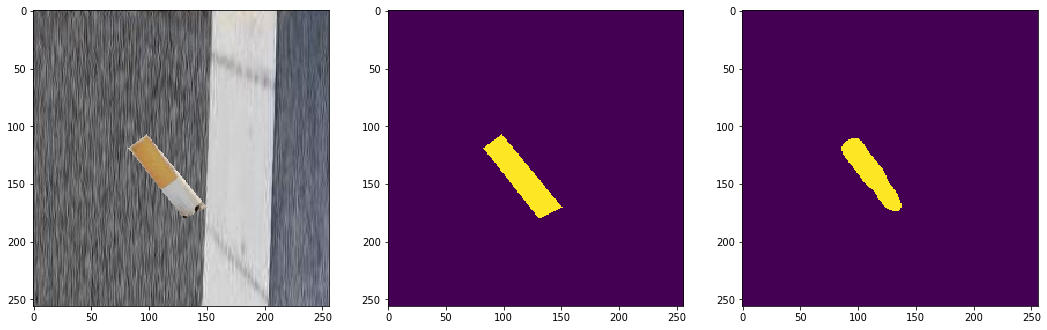

In [63]:

def view_img_mask(img, mask , model, thres_val):
    if model:
        pred = model.predict(np.expand_dims(img, axis=0)).reshape((1, img.shape[0], img.shape[1], 1))
        pred = np.squeeze(pred)
        fig, ax = plt.subplots(1 , 3, figsize=(18, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)
        ax[2].imshow(pred > thres_val)
    else:
        fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)

img_index = 495

# view_img_mask(train_ds[img_index][0], train_ds[img_index][1], base_model)
view_img_mask(val[img_index], val_mask[img_index].reshape(256,256), base_model, 0.38)

# print(train_ds[img_index][1])
# print(mask[img_index])

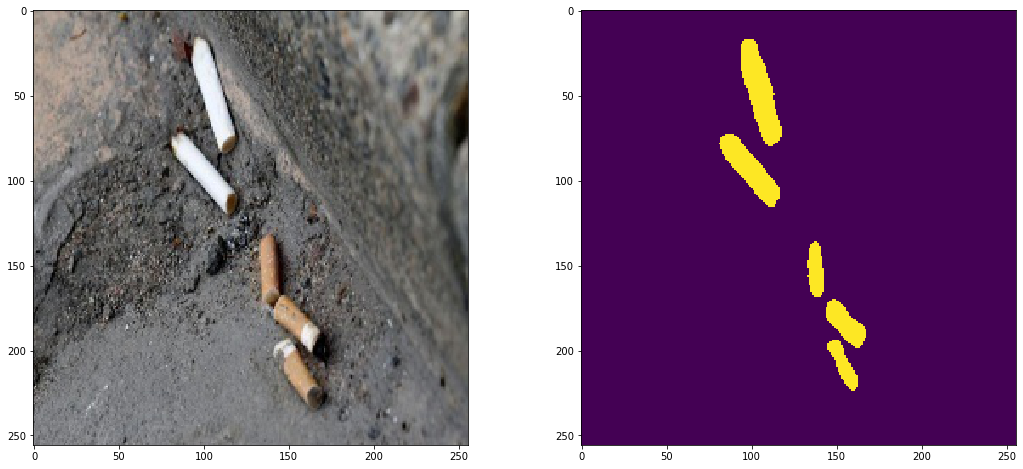

In [51]:
# predict on a test image
img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-2.jpg')
pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, 256, 256, 1))
pred = np.squeeze(pred)
cv2.imwrite('pred_test_2.jpg', (pred > 0.38).astype(float) *255 )
fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
ax[0].imshow(img)
ax[1].imshow(pred > 0.38)

In [21]:
def predict_img(img_path, thres_val):
    # img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-9.jpg')
    resize_image('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test')
    img = plt.imread(img_path)
    pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, config.IMG_WIDTH, config.IMG_HEIGHT, 1))
    pred = np.squeeze(pred)
    fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
    ax[0].imshow(img)
    ax[1].imshow(pred > thres_val)


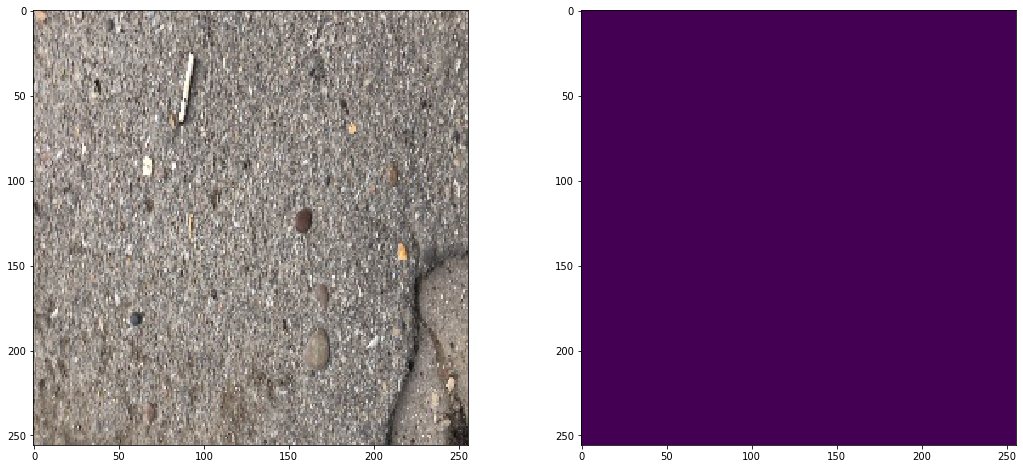

In [29]:
import cv2
predict_img('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/video_test/image1.jpg')

In [34]:
def video_predict(file_path, model, thresh_val):
    '''
    Read video and predict on each frame.
    Args:
        filename(str)
    '''
    def getFrame(sec):
        video_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/video_test'
        vidcap = cv2.VideoCapture(file_path)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            image = cv2.resize(image, (config.IMG_WIDTH, config.IMG_HEIGHT))
            pred_img = base_model.predict(np.expand_dims(image, axis=0)).reshape((1, config.IMG_WIDTH, config.IMG_HEIGHT, 1))
            pred_img = np.squeeze(pred_img)
            cv2.imwrite(os.path.join(video_path,"pred_image"+str(count)+".jpg"), (pred_img > thresh_val).astype(float) * 255)
            cv2.imwrite(os.path.join(video_path,"image"+str(count)+".jpg"), image)

        return hasFrames

    sec = 0
    frameRate = 1 #//it will capture image in each 0.5 second
    count = 1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)


In [36]:
video_predict('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/IMG_9429.mp4', base_model , 0.12)